In [1]:
from sklearn import datasets
import scanpy as sc
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np

import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, MLP_bridge, MLP_marginal,MLP_fused_vector_field
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from sklearn import preprocessing as pp

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
2023-09-11 19:37:58.877747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not 

In [2]:
adata = sc.read("../../data/adata_pancreas_2019.h5ad")

In [3]:
adata = adata[adata.obs["celltype"]!="Multipotent"].copy()
adata.obs["lineage"] = adata.obs.apply(lambda x: "A" if x["celltype"] in ["Acinar", "Tip"] else "ED", axis=1).astype("category")

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


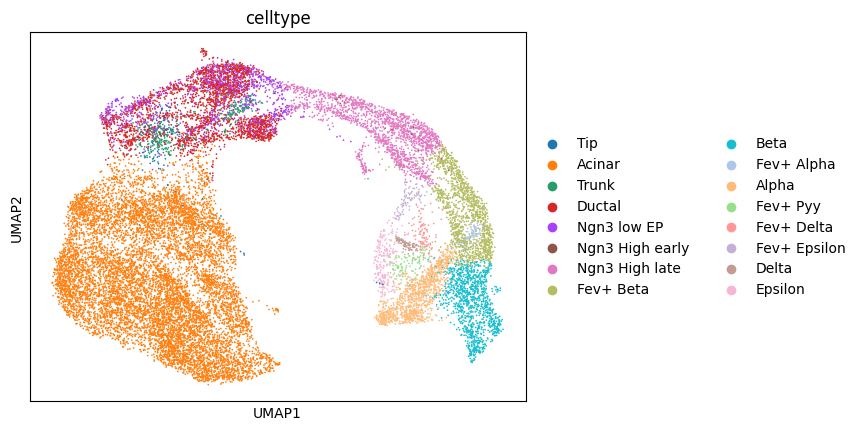

In [4]:
sc.pl.umap(adata, color="celltype")

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


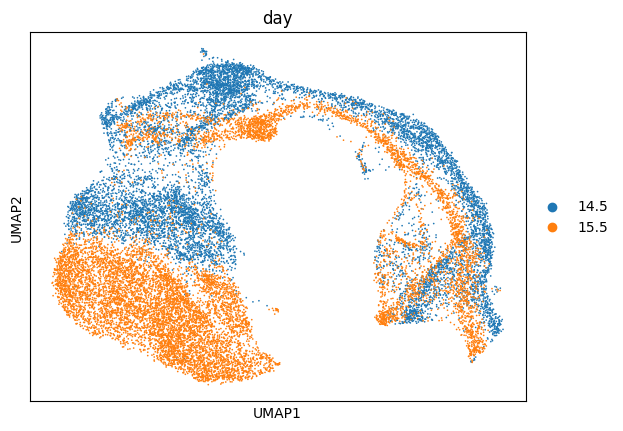

In [5]:
sc.pl.umap(adata, color="day")

In [6]:
sc.pp.pca(adata, n_comps=30)
adata.obsm["X_pca_scaled"] = pp.StandardScaler().fit_transform(adata.obsm["X_pca"])

In [7]:
n_cells_source=len(adata[adata.obs["day"]=="14.5"])
n_cells_target=len(adata[adata.obs["day"]=="15.5"])

n_samples_train_source = int(n_cells_source * 0.6)
n_samples_test_source = n_cells_source - n_samples_train_source

n_samples_train_target = int(n_cells_target * 0.6)
n_samples_test_target = n_cells_target - n_samples_train_target

inds_source_train = np.asarray(jax.random.choice(jax.random.PRNGKey(0), n_cells_source, (n_samples_train_source,), replace=False))
inds_source_test = list(set(list(range(n_samples_train_source))) - set(inds_source_train))

inds_target_train = np.asarray(list(jax.random.choice(jax.random.PRNGKey(1), n_cells_target, (n_samples_train_target,), replace=False)))
inds_target_test = list(set(list(range(n_samples_train_target))) - set(inds_target_train))

adata_source_train = adata[inds_source_train,:]
adata_source_test = adata[inds_source_test,:]

adata_target_train = adata[inds_target_train,:]
adata_target_test = adata[inds_target_test,:]

source_train = adata_source_train.obsm["X_pca_scaled"]
source_test = adata_source_test.obsm["X_pca_scaled"]
target_train = adata_target_train.obsm["X_pca_scaled"]
target_test = adata_target_test.obsm["X_pca_scaled"]

2023-09-11 19:41:22.529434: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.128). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [9]:
ot_solver=ott.solvers.linear.sinkhorn.Sinkhorn()
neural_net = MLP_vector_field(target_train.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)
bridge_net = MLP_bridge(target_train.shape[1], 10)


mlp_eta = MLP_marginal(256, 5)
mlp_xi = MLP_marginal(256, 5)


otfm = OTFlowMatching(neural_net, bridge_net=bridge_net, ot_solver=ot_solver, epsilon=1e-1, mlp_eta=mlp_eta, mlp_xi=mlp_xi, tau_a=0.95, tau_b=0.95, input_dim=30, output_dim=30, iterations=5_000, k_noise_per_x=1)

In [10]:
otfm(source_train, target_train, 1024, 1024)

100%|██████████| 5000/5000 [01:12<00:00, 69.26it/s]


In [11]:

res = [None] * 30

for i in range(30):
    res[i] = otfm.transport(source_test, seed=i)[0][0,...]

gex_predicted = jnp.mean(np.asarray(res), axis=0)

In [12]:
bdata = sc.concat(
    [adata_source_test, adata_target_test],
    join="outer",
    label="day",
    keys=["14.5", "15.5"],
)

bdata.obsm["X_pca_result"] = np.concatenate((gex_predicted, target_test), axis=0)

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [13]:
sc.pp.neighbors(bdata, use_rep="X_pca_result")

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/

In [14]:
sc.tl.umap(bdata)

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


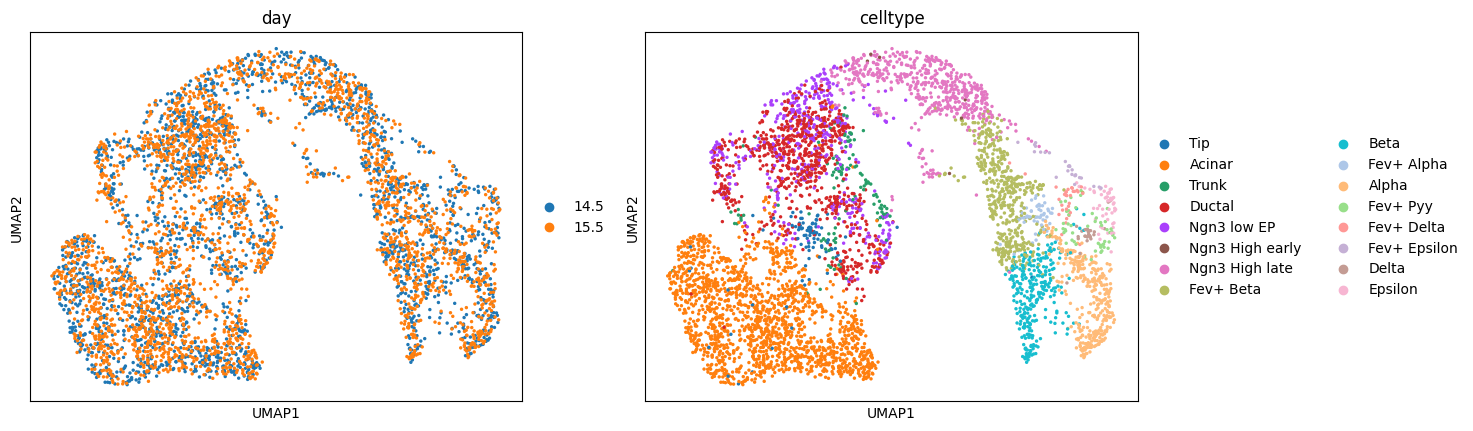

In [15]:
sc.pl.umap(bdata, color=["day", "celltype"])

In [16]:
from typing import Tuple, Callable, Union, List, Optional
import scipy.sparse as sp
import jax.numpy as jnp
import jax
import pandas as pd

def get_nearest_neighbors(
    input_batch: jnp.ndarray, target: jnp.ndarray, k: int = 30
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Get the k nearest neighbors of the input batch in the target."""
    if target.shape[0] < k:
        raise ValueError(f"k is {k}, but must be smaller or equal than {target.shape[0]}.")
    pairwise_euclidean_distances = jnp.sqrt(jnp.sum((input_batch - target) ** 2, axis=-1))
    negative_distances, indices = jax.lax.top_k(-1 * pairwise_euclidean_distances, k=k)
    return -1 * negative_distances, indices

def project_transport_matrix(  
        predicted_tgt_cells: jnp.ndarray,
        tgt_cells: jnp.ndarray,
        batch_size: int = 1024,
        k: int = 1,
    ) -> sp.csr_matrix:
        """Project Neural OT map onto cells."""

        get_knn_fn = jax.vmap(get_nearest_neighbors, in_axes=(0, None, None))
        row_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        column_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        distances_list: Union[jnp.ndarray, List[jnp.ndarray]] = []
        for index in range(0, len(predicted_tgt_cells), batch_size):
            _, indices = get_knn_fn(predicted_tgt_cells[index : index + batch_size], tgt_cells, k)
            column_indices.append(indices.flatten())
            row_indices.append(
                jnp.repeat(jnp.arange(index, index + min(batch_size, len(predicted_tgt_cells) - index)), min(k, len(tgt_cells)))
            )
        ri = jnp.concatenate(row_indices)
        ci = jnp.concatenate(column_indices)
        mat = np.zeros((len(ri), len(tgt_cells)))
        mat[ri,ci] = 1.0
        return mat

def aggregate_transport_matrix(adata_source, adata_target, tmat, aggregation_key = "celltype", forward = True):
    df_source = adata_source.obs[aggregation_key]
    df_target = adata_target.obs[aggregation_key]

    annotations_source = adata_source.obs[aggregation_key].cat.categories
    annotations_target = adata_target.obs[aggregation_key].cat.categories

    tm = pd.DataFrame(
        np.zeros((len(annotations_source), len(annotations_target))),
        index=annotations_source,
        columns=annotations_target,
    )
    
    for annotation_src in annotations_source:
        for annotation_tgt in annotations_target:
            tm.loc[annotation_src, annotation_tgt] = tmat[
                np.ix_((df_source == annotation_src).squeeze(), (df_target == annotation_tgt).squeeze())
            ].sum()
    return tm.div(tm.sum(axis=int(forward)), axis=int(not forward))

In [18]:
tm = project_transport_matrix(gex_predicted, target_test)
agg_tm = aggregate_transport_matrix(adata_source_test, adata_target_test, tm, forward=False)

In [19]:
agg_tm

,Tip,Acinar,Trunk,Ductal,Ngn3 low EP,Ngn3 High early,Ngn3 High late,Fev+ Beta,Beta,Fev+ Alpha,Alpha,Fev+ Pyy,Fev+ Delta,Fev+ Epsilon,Delta,Epsilon
Tip,0.84375,0.013959,0.000000,0.021858,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
Acinar,0.00000,0.970812,0.048780,0.008197,0.010417,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
Trunk,0.03125,0.002538,0.829268,0.035519,0.072917,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
Ductal,0.12500,0.011421,0.073171,0.653005,0.463542,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
Ngn3 low EP,0.00000,0.001269,0.048780,0.278689,0.427083,NaN,0.045643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
Ngn3 High early,0.00000,0.000000,0.000000,0.000000,0.000000,NaN,0.012448,0.004202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
Ngn3 High late,0.00000,0.000000,0.000000,0.002732,0.026042,NaN,0.933610,0.088235,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.000,0.000000
Fev+ Beta,0.00000,0.000000,0.000000,0.000000,0.000000,NaN,0.008299,0.815126,0.047244,0.363636,0.000000,0.047619,0.000000,0.000000,0.000,0.000000
Beta,0.00000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.033613,0.897638,0.030303,0.054422,0.047619,0.000000,0.055556,0.000,0.028571
Fev+ Alpha,0.00000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.046218,0.000000,0.454545,0.013605,0.047619,0.000000,0.000000,0.000,0.000000


In [21]:
agg_tm = aggregate_transport_matrix(adata_source_test, adata_target_test, tm, aggregation_key="lineage", forward=False)

In [22]:
agg_tm

,A,ED
A,0.979268,0.010142
ED,0.020732,0.989858


In [23]:
agg_tm = aggregate_transport_matrix(adata_source_test, adata_target_test, tm, aggregation_key="lineage", forward=True)
agg_tm

,A,ED
A,0.981663,0.018337
ED,0.011479,0.988521


In [24]:
full_test_data = jnp.concatenate((source_test, target_test), axis=0)
bdata.obs["left_marginals"] = otfm.state_eta.apply_fn({"params": otfm.state_eta.params}, x=full_test_data)
bdata.obs["right_marginals"] = otfm.state_xi.apply_fn({"params": otfm.state_xi.params}, x=full_test_data)

In [31]:
bdata.obs["left_marginals_source"] = bdata.obs.apply(lambda x: x["left_marginals"] if x["day"]=="14.5" else None, axis=1)
bdata.obs["left_marginals_target"] = bdata.obs.apply(lambda x: x["left_marginals"] if x["day"]=="15.5" else None, axis=1)
bdata.obs["right_marginals_target"] = bdata.obs.apply(lambda x: x["right_marginals"] if x["day"]=="15.5" else None, axis=1)
bdata.obs["right_marginals_source"] = bdata.obs.apply(lambda x: x["right_marginals"] if x["day"]=="14.5" else None, axis=1)

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


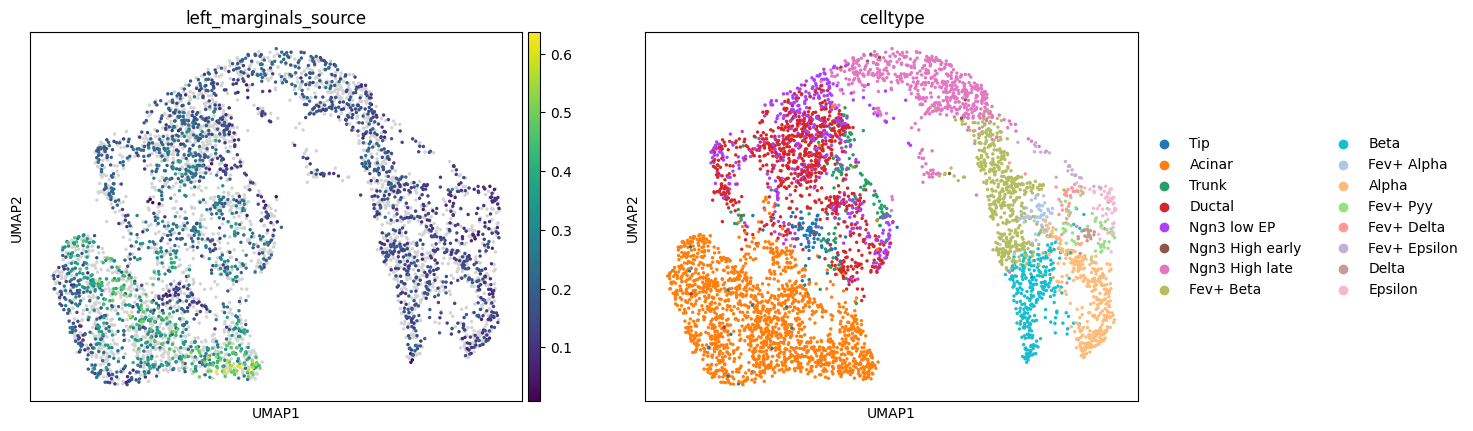

In [32]:
sc.pl.umap(bdata, color=["left_marginals_source", "celltype"])

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


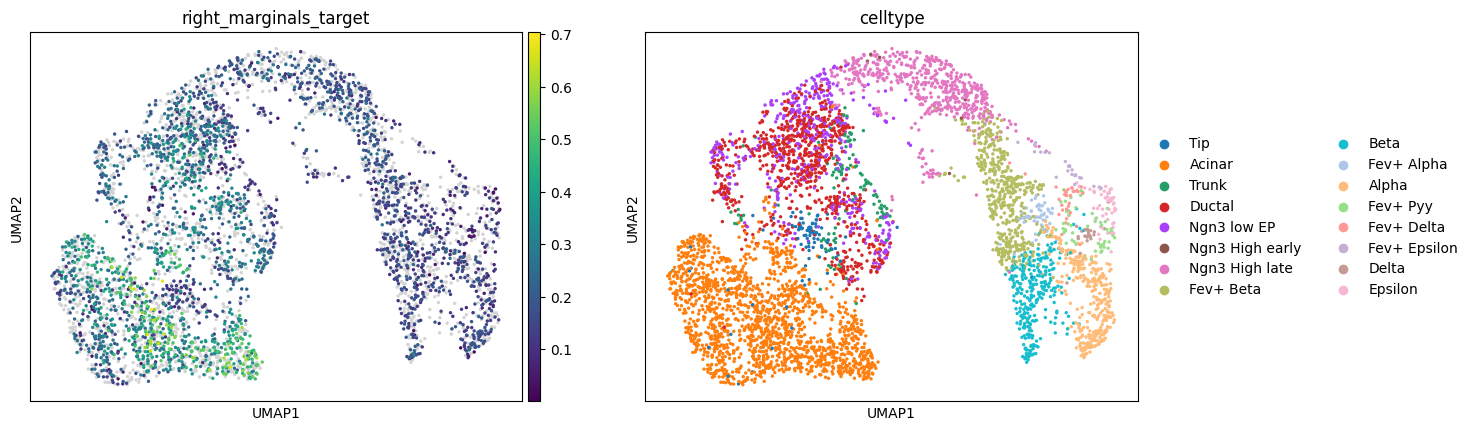

In [33]:
sc.pl.umap(bdata, color=["right_marginals_target", "celltype"])

In [38]:
bdata.obs[["left_marginals_source", "left_marginals_target", "right_marginals_source", "right_marginals_target", "lineage"]].groupby("lineage").mean()

,left_marginals_source,left_marginals_target,right_marginals_source,right_marginals_target
lineage,,,,
A,0.289817,0.278464,0.303219,0.318225
ED,0.165620,0.157191,0.164523,0.184243
